In [1]:
%matplotlib inline

In [2]:
import numpy as np
import nengo
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt

In [3]:
def go(transition=[0, 1],
       ensemble_seed=0,
       n=50,
       neuron_type=nengo.AdaptiveLIFRate(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=0.5),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False):

    d = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
    
    A = 2*np.pi*freq
    syn_train=nengo.Lowpass(tau)

    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: A*np.cos(A*t))
            presyn = nengo.Node(size_in=1)  # tau*dot{x} + x == tau*u + int{u}
            x = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=ensemble_seed)
            
            nengo.Connection(stim, presyn, synapse=None, transform=tau)
            nengo.Connection(x, presyn, synapse=None, transform=p,
                             solver=nengo.solvers.NoSolver(d))
            nengo.Connection(stim, presyn, synapse=1/s, transform=1-p)
            nengo.Connection(presyn, x, synapse=tau)
            
            p_a = nengo.Probe(x.neurons, synapse=None)
            p_x = nengo.Probe(presyn, synapse=tau)
            p_y = nengo.Probe(stim, synapse=1/s)
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)

        new_d, _ = solver(syn_train.filt(sim.data[p_a]),
                          syn_train.filt(sim.data[p_y]))
        e = nengolib.signal.nrmse(sim.data[p_x], target=sim.data[p_y])
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(new_d - d)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
        d = new_d
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), sim.data[p_y], label=r"$x$", linestyle='--')
            plt.plot(sim.trange(), sim.data[p_x], label=r"$\hat{x}$")
            plt.legend()
            plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

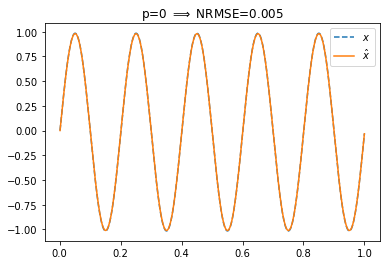

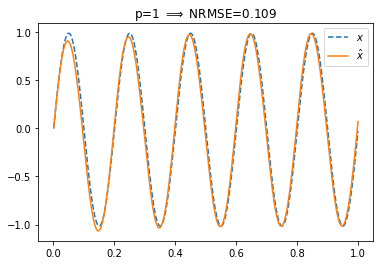

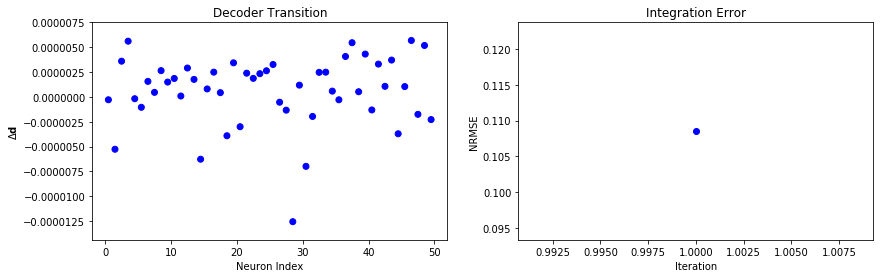

In [65]:
go(verbose=True)

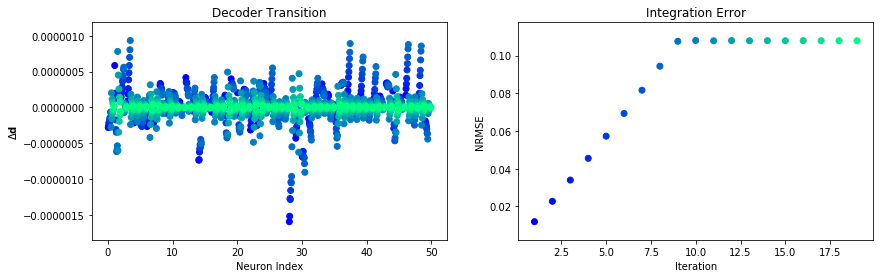

In [9]:
go(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))))

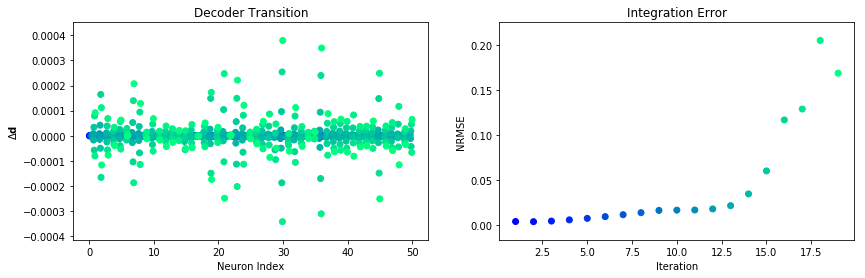

In [10]:
go(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
   solver=nengo.solvers.LstsqL2(reg=0.1))

## New method uses a network which permits neuron_type=Bahlneuron() substituion

In [197]:
def go2(transition=[0, 1],
       ensemble_seed=0,
       n=50,
       neuron_type=nengo.AdaptiveLIFRate(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=0.5),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False,
       spikes2inter=False,
       n_pre2=50,
       tau_pre2=0.01):

    d = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
 
    # first find the norm of the signal (not filtered)
    A = 2*np.pi*freq
        
    # first solve for "inter" decoders, which will be used to compute
    # weights on the inter_bio connection
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(A*t))
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=ensemble_seed)

        nengo.Connection(stim, inter, synapse=1/s, transform=A)
        
        p_a = nengo.Probe(inter.neurons, synapse=tau)
        p_y = nengo.Probe(stim, synapse=1/s)
       
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)

    target = A*nengo.Lowpass(tau).filt(sim.data[p_y])
    d_inter, _ = solver(sim.data[p_a], target)
    xhat_inter = np.dot(sim.data[p_a], d_inter)
    e_inter = nengolib.signal.nrmse(xhat_inter, target=target)
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode $\Longrightarrow$ NRMSE=%.3f" %e_inter)
        plt.plot(sim.trange(), target, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_inter, label=r"$\hat{x}$")
        plt.legend()
        plt.show()

        
    # now solve for the readout/recurrent decoders
    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: np.cos(A*t))
            pre = nengo.Ensemble(n, 1, neuron_type=nengo.LIF(), seed=ensemble_seed)
            pre2 = nengo.Ensemble(n_pre2, 1, neuron_type=nengo.LIF(), seed=ensemble_seed)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=ensemble_seed)
            x = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=ensemble_seed)
            y = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=ensemble_seed)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(pre, x, synapse=tau, transform=A*tau)
            # for inter neuron_type=bioneuron
            if spikes2inter:  
                nengo.Connection(stim, pre2, synapse=1/s)
                # tau_pre2_inter must be nonzero for bioneurons,
                # but how do we account for extra filter?
                nengo.Connection(pre2, inter, synapse=tau_pre2, transform=A)
            # for inter neuron_type!=bioneuron
            else:
                nengo.Connection(stim, inter, synapse=1/s, transform=A)
            nengo.Connection(x, x, synapse=tau, transform=p,
                            solver=nengo.solvers.NoSolver(d))
            nengo.Connection(inter, x, synapse=tau, transform=1-p,
                            solver=nengo.solvers.NoSolver(d_inter))
            nengo.Connection(stim, y, synapse=1/s, transform=A)
            
            p_a = nengo.Probe(x.neurons, synapse=tau)
            p_x = nengo.Probe(x, synapse=tau, solver=nengo.solvers.NoSolver(d))
            p_y = nengo.Probe(y, synapse=tau)
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)
        
        new_d, _ = solver(sim.data[p_a], sim.data[p_y])
        xhat = np.dot(sim.data[p_a], new_d)
        e = nengolib.signal.nrmse(xhat, target=sim.data[p_y])
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(new_d - d)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
        d = new_d
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), sim.data[p_y], label=r"$x$", linestyle='--')
            plt.plot(sim.trange(), xhat, label=r"$\hat{x}$")
            plt.legend()
            plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

Good regularization

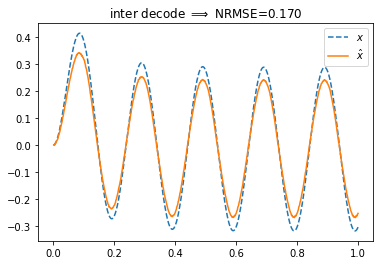

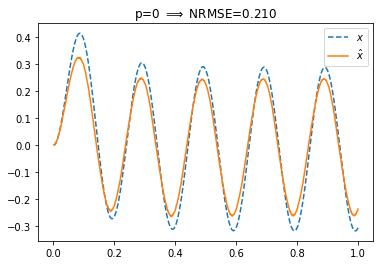

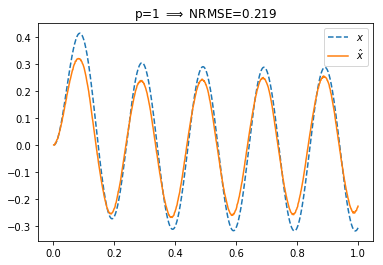

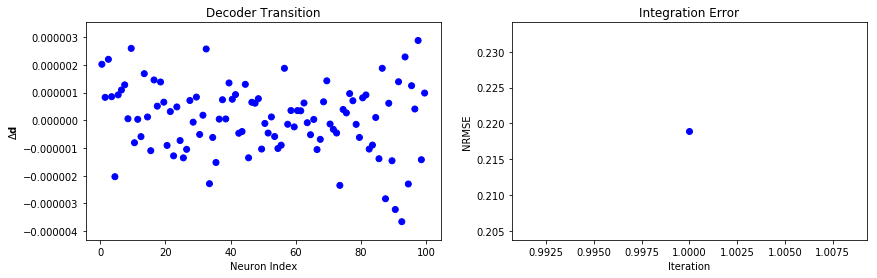

In [198]:
go2(n=100,
    verbose=True,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    solver=nengo.solvers.LstsqL2(reg=0.5),
    spikes2inter=False)

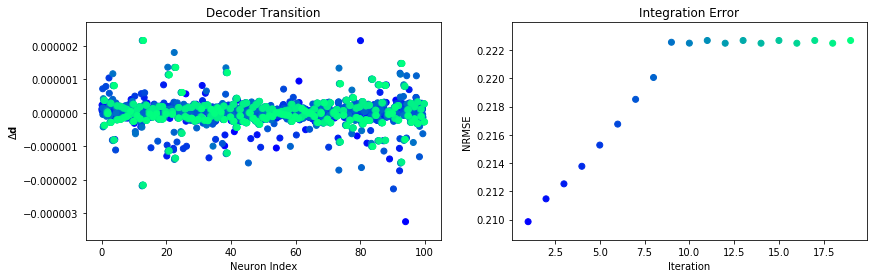

In [180]:
go2(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    n=100,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    spikes2inter=False,
    solver=nengo.solvers.LstsqL2(reg=0.5))

Bad regularization

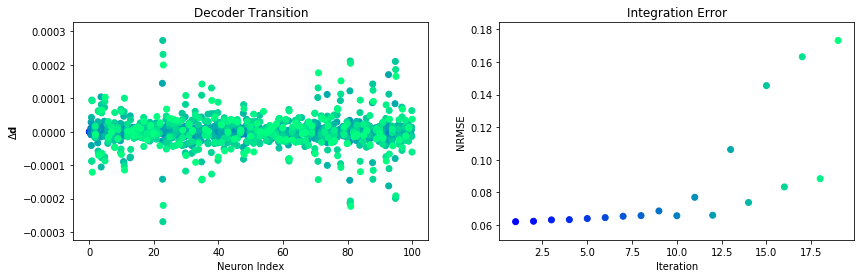

In [181]:
go2(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    n=100,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    spikes2inter=False,
    solver=nengo.solvers.LstsqL2(reg=0.1))

Bad representation of the training signal

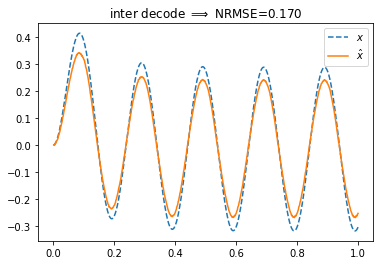

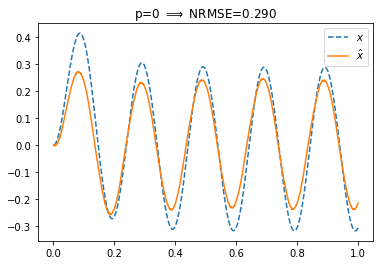

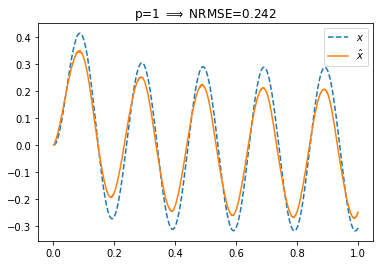

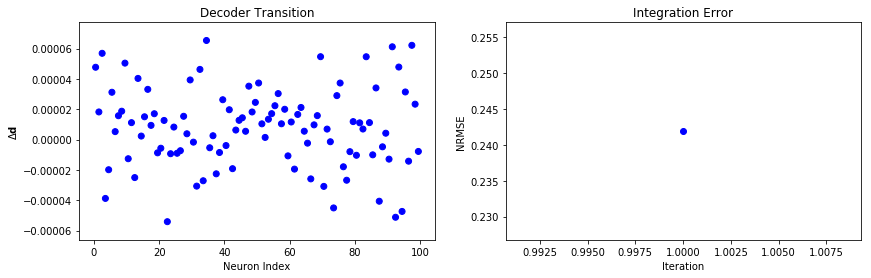

In [182]:
go2(n=100,
    verbose=True,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    spikes2inter=True,
    n_pre2=100)

Good representation of the training signal

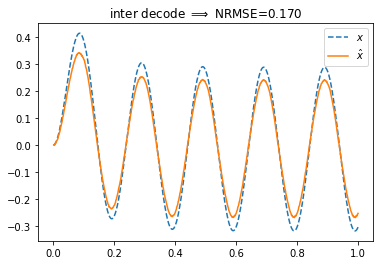

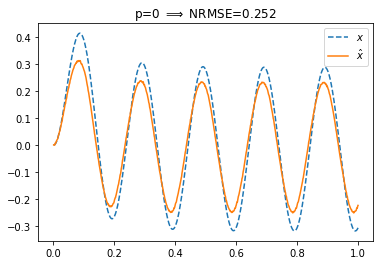

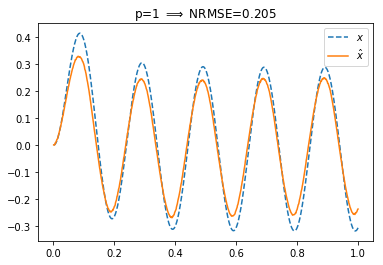

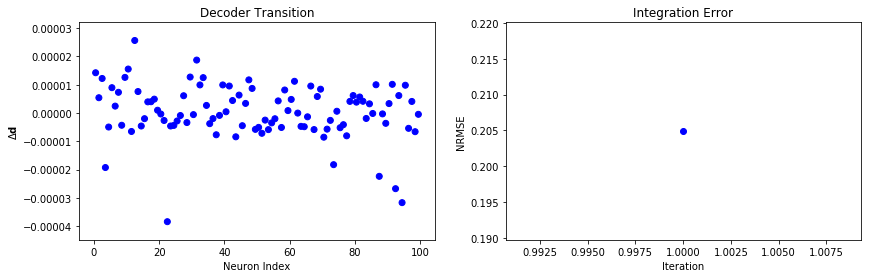

In [183]:
go2(n=100,
    verbose=True,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    spikes2inter=True,
    n_pre2=1000,
    tau_pre2=0.02)

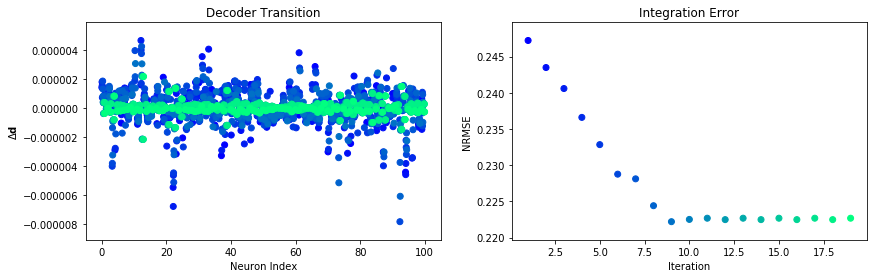

In [184]:
go2(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    n=100,
    verbose=False,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    spikes2inter=True,
    n_pre2=1000,
    tau_pre2=0.02)

## Normalized Version of go2

In [297]:
def go3(transition=[0, 1],
       es=0,
       cs=1,
       n=50,
       neuron_type=nengo.AdaptiveLIFRate(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=0.5),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False,
       spikes2inter=False,
       n_pre2=50,
       tau_pre2=0.01):

    d_bio = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
 
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    lpf2=nengo.Lowpass(tau_pre2)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_ff = np.max(np.abs(target_ff))
    norm_f2f = np.max(np.abs(target_f2f))
    
    # now solve for "inter" decoders, which will be used to compute
    # weights on the inter_bio connection
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre2, synapse=1/s)
        nengo.Connection(pre2, inter, synapse=tau_pre2, transform=1.0/norm_f2f, seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f2f)
        p_a = nengo.Probe(inter.neurons, synapse=None)
        p_integral = nengo.Probe(tar, synapse=None)     
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    act_f = lpf.filt(sim.data[p_a])
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    d_inter, _ = solver(act_f, target_f2f)
    xhat_inter = np.dot(act_f, d_inter)
    e_inter = nengolib.signal.nrmse(xhat_inter, target=target_f2f)
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode $\Longrightarrow$ NRMSE=%.3f" %e_inter)
        plt.plot(sim.trange(), target_f2f, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_inter, label=r"$\hat{x}$")
        plt.legend()
        plt.show()

        
    # now solve for the readout/recurrent decoders
    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
            pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
            pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(pre, bio, synapse=tau, transform=tau/norm_f, seed=cs)
            nengo.Connection(stim, pre2, synapse=1/s)
            nengo.Connection(pre2, inter, synapse=tau_pre2, transform=1.0/norm_f, seed=cs)
            nengo.Connection(bio, bio,
                             synapse=tau,
                             transform=p,
                             solver=nengo.solvers.NoSolver(d_bio),
                             seed=cs)
            nengo.Connection(inter, bio,
                             synapse=tau,
                             transform=1-p,
                             solver=nengo.solvers.NoSolver(d_inter),
                             seed=cs)
            nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)
            
            p_a = nengo.Probe(bio.neurons, synapse=None)
            p_i = nengo.Probe(inter, synapse=tau, solver=nengo.solvers.NoSolver(d_inter))
            p_integral = nengo.Probe(tar, synapse=None)
            p_bio = nengo.Probe(bio, synapse=tau, solver=nengo.solvers.NoSolver(d_bio))
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)
        
        act_f = lpf.filt(sim.data[p_a])
        target_f = lpf.filt(sim.data[p_integral])
        target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
        d_bio_new, _ = solver(act_f, target_f)
        xhat_bio = np.dot(act_f, d_bio_new)
        e = nengolib.signal.nrmse(xhat_bio, target=target_f)
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(d_bio_new - d_bio)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
            
        d_bio = d_bio_new
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), target_f, label=r"$x_f$", linestyle='--')
#             plt.plot(sim.trange(), target_ff, label=r"$x_{ff}$", linestyle='--')
            plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
#             plt.plot(sim.trange(), sim.data[p_i], label=r"$\hat{x}_{inter}$")
            plt.legend()
            plt.show()
#             plt.figure()
#             plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
#             plt.plot(sim.trange(), act_f, label=r"$a$", linestyle='-')
#             plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

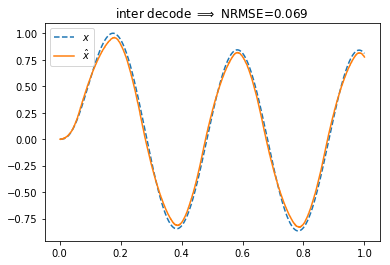

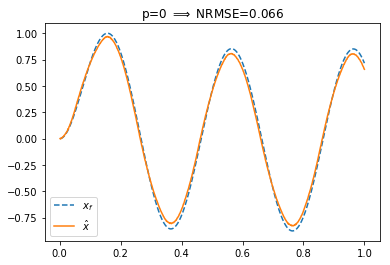

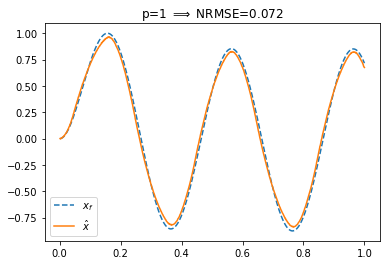

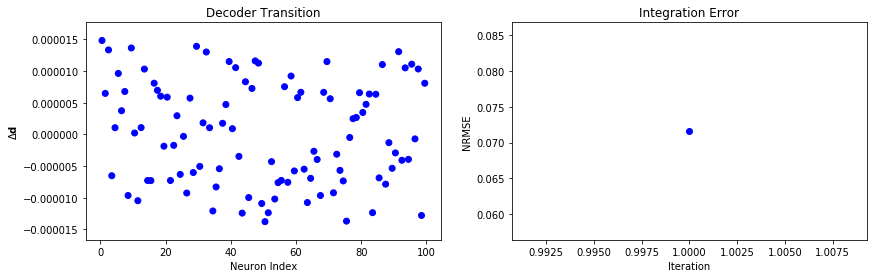

In [298]:
go3(n=100,
    freq=5*np.pi,
    verbose=True,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.02)

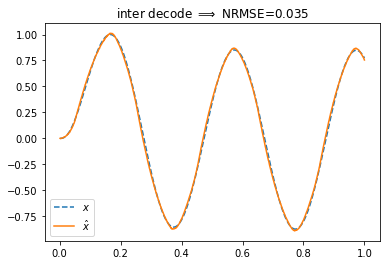

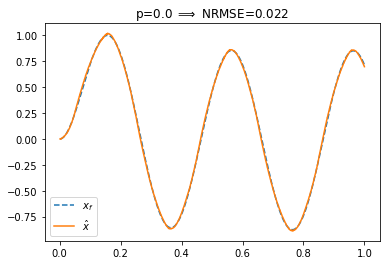

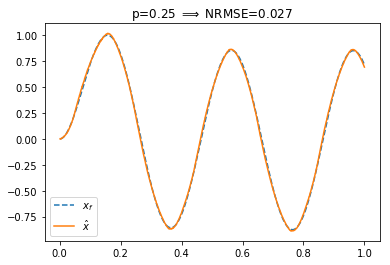

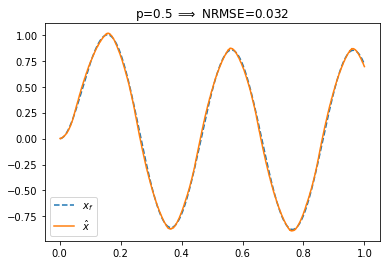

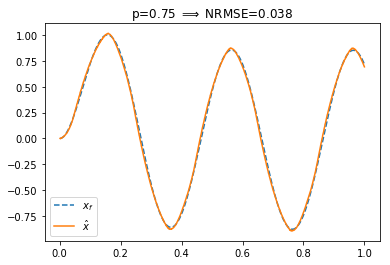

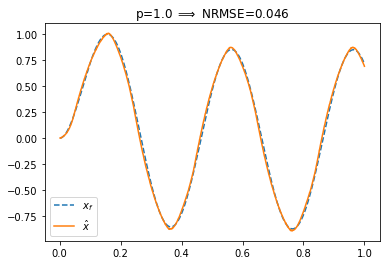

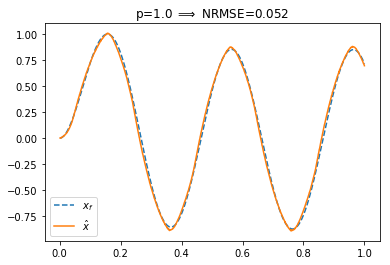

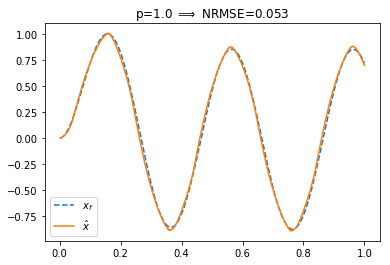

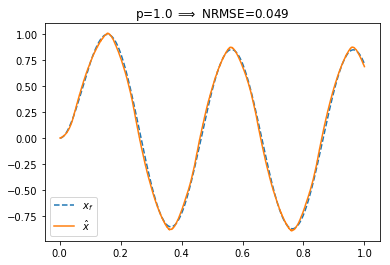

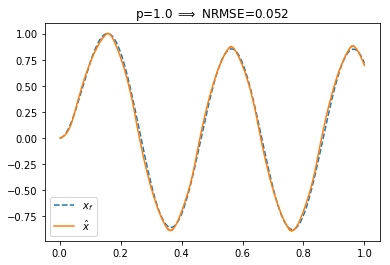

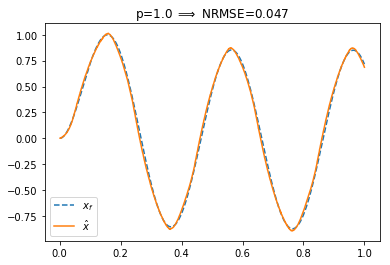

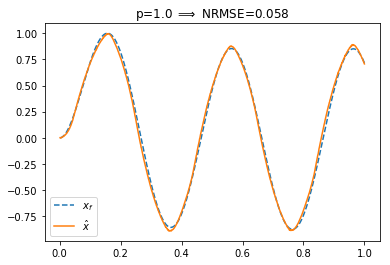

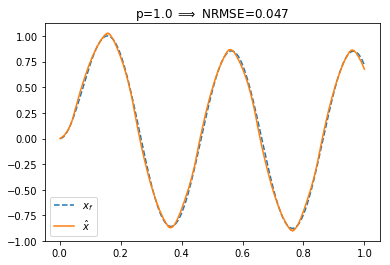

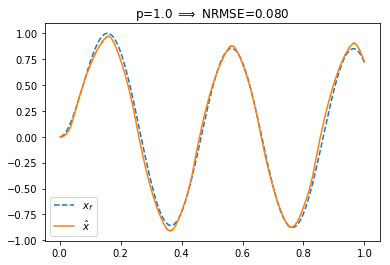

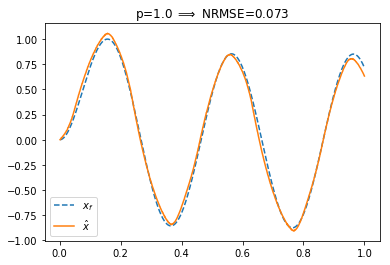

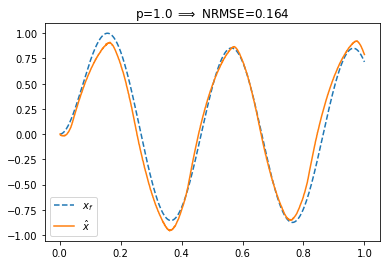

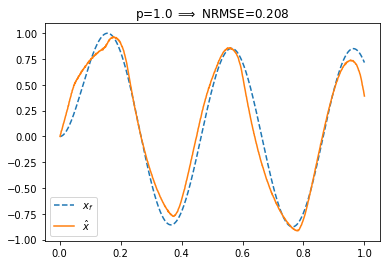

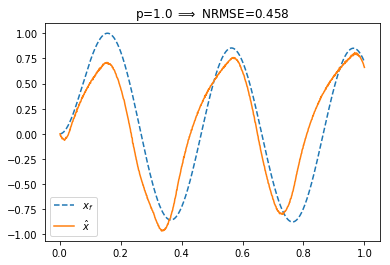

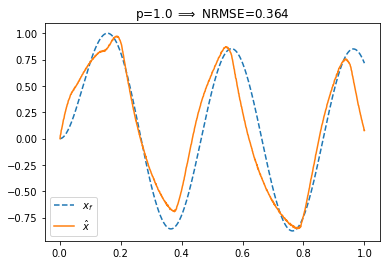

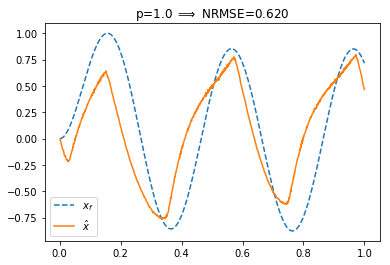

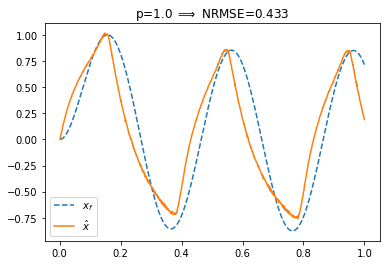

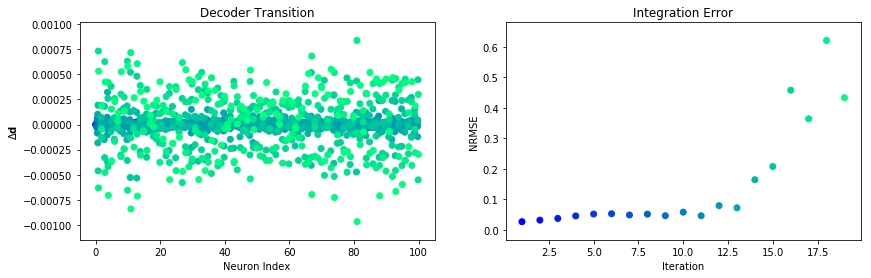

In [320]:
go3(np.concatenate((np.linspace(0, 1, 5), np.repeat(1, 15))),
    n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=0.1),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01)

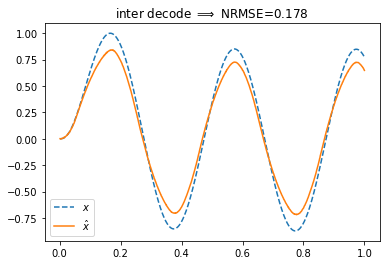

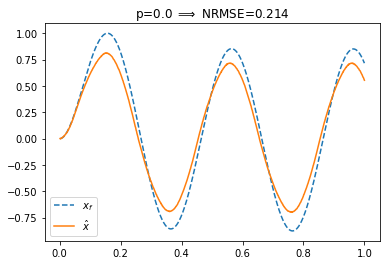

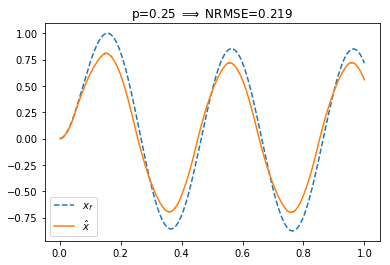

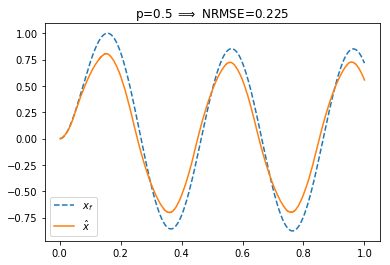

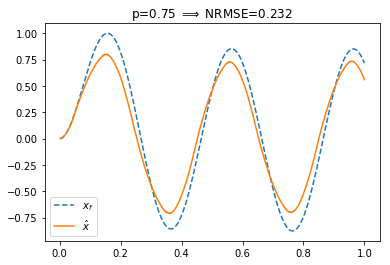

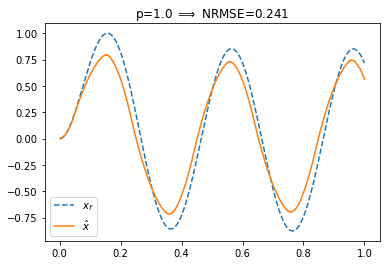

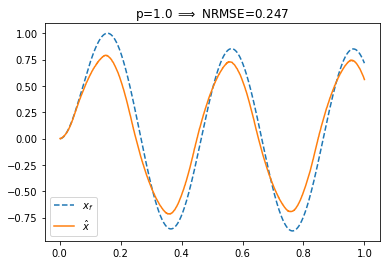

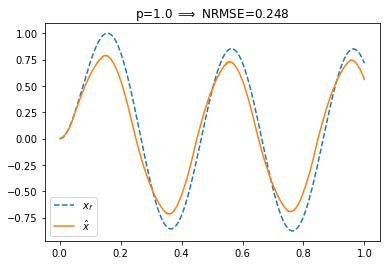

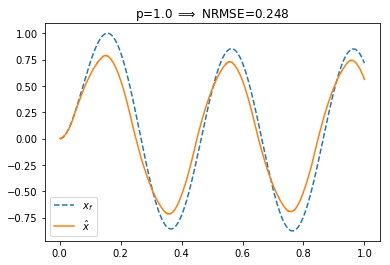

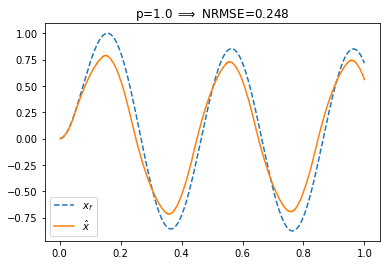

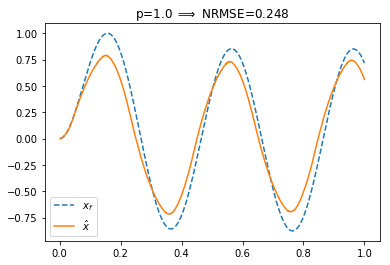

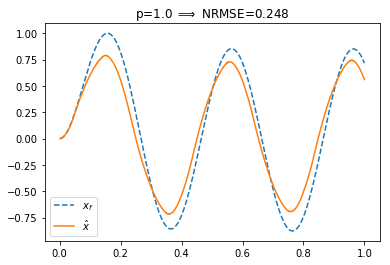

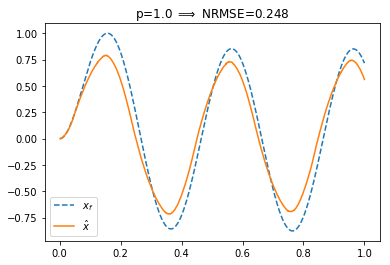

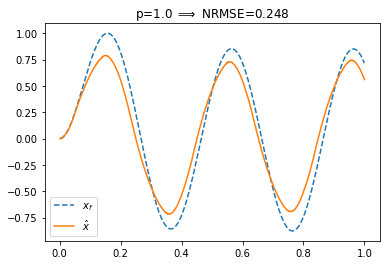

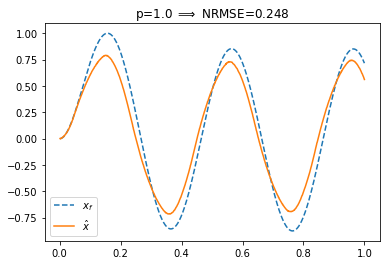

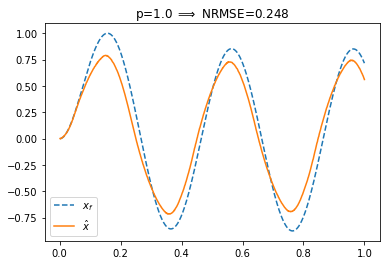

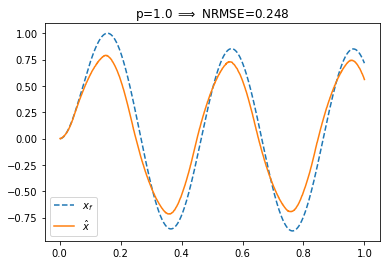

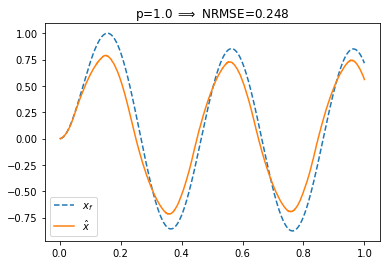

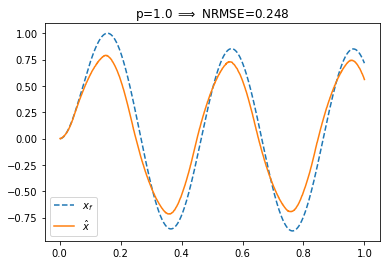

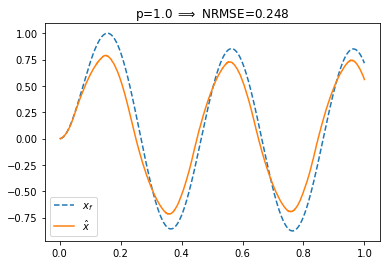

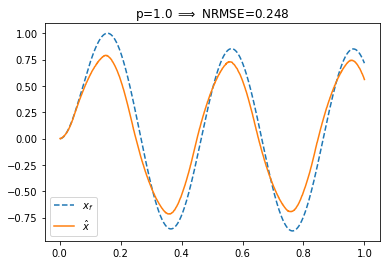

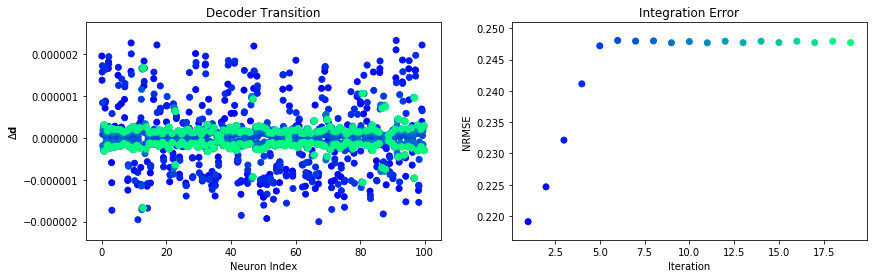

In [321]:
go3(np.concatenate((np.linspace(0, 1, 5), np.repeat(1, 15))),
    n=100,
    freq=5*np.pi,
    verbose=True,
    solver=nengo.solvers.LstsqL2(reg=1.0),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01)

After some testing, looks like using a low reg (reg=0.1) leads to very high accuracy just after the transition, but continuing to apply decoder update leads to oscillating exponential noise, as Aaron pointed out for go(). Higher reg (reg>0.9) leads to lower accuracy (consistent undershoot of the signal), but no grown in the error oscillation.

## Onto the Bioneurons!

In [324]:
from nengo_bioneurons import BahlNeuron, build_filter


def go4(transition=[0, 1],
       es=0,
       cs=1,
       n=50,
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=1.0),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False,
       n_pre2=50,
       tau_pre2=0.01,
       n_syn=1):

    d_bio = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
 
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    lpf2=nengo.Lowpass(tau_pre2)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_ff = np.max(np.abs(target_ff))
    norm_f2f = np.max(np.abs(target_f2f))
    
    # now solve for "inter" decoders, which will be used to compute
    # weights on the inter_bio connection
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre2, synapse=1/s)
        nengo.Connection(pre2, inter,
                         sec='apical',
                         n_syn=n_syn,
                         syn_type='ExpSyn',
                         tau_list=[tau_pre2],
                         synapse=tau_pre2,
                         transform=1.0/norm_f2f,
                         seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f2f)
        p_a = nengo.Probe(inter.neurons, synapse=None)
        p_integral = nengo.Probe(tar, synapse=None)     
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    act_f = lpf.filt(sim.data[p_a])
    target_f2f = lpf.filt(lpf2.filt(sim.data[p_integral]))
    d_inter, _ = solver(act_f, target_f2f)
    xhat_inter = np.dot(act_f, d_inter)
    e_inter = nengolib.signal.nrmse(xhat_inter, target=target_f2f)
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode $\Longrightarrow$ NRMSE=%.3f" %e_inter)
        plt.plot(sim.trange(), target_f2f, label=r"$x$", linestyle='--')
        plt.plot(sim.trange(), xhat_inter, label=r"$\hat{x}$")
        plt.legend()
        plt.show()

        
    # now solve for the readout/recurrent decoders
    for i, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
            pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
            pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(pre, bio,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=tau/norm_f,
                             seed=cs)
            nengo.Connection(stim, pre2, synapse=1/s)
            nengo.Connection(pre2, inter,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau_pre2],
                             synapse=tau_pre2,
                             transform=1.0/norm_f,
                             seed=cs)
            nengo.Connection(bio, bio,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=p,
                             solver=nengo.solvers.NoSolver(d_bio),
                             seed=cs)
            nengo.Connection(inter, bio,
                             sec='apical',
                             n_syn=n_syn,
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=1-p,
                             solver=nengo.solvers.NoSolver(d_inter),
                             seed=cs)
            nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)
            
            p_a = nengo.Probe(bio.neurons, synapse=None)
            p_i = nengo.Probe(inter, synapse=tau, solver=nengo.solvers.NoSolver(d_inter))
            p_integral = nengo.Probe(tar, synapse=None)
            p_bio = nengo.Probe(bio, synapse=tau, solver=nengo.solvers.NoSolver(d_bio))
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)
        
        act_f = lpf.filt(sim.data[p_a])
        target_f = lpf.filt(sim.data[p_integral])
        target_ff = lpf.filt(lpf.filt(sim.data[p_integral]))
        d_bio_new, _ = solver(act_f, target_f)
        xhat_bio = np.dot(act_f, d_bio_new)
        e = nengolib.signal.nrmse(xhat_bio, target=target_f)
        
        if i > 0:
            scatter_x.extend(np.arange(n) + i / float(len(transition)))
            scatter_y.extend(d_bio_new - d_bio)
            scatter_c.extend([i]*n)
            scatter_e.append(e)
            
        d_bio = d_bio_new
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), target_f, label=r"$x_f$", linestyle='--')
#             plt.plot(sim.trange(), target_ff, label=r"$x_{ff}$", linestyle='--')
            plt.plot(sim.trange(), xhat_bio, label=r"$\hat{x}$")
            plt.plot(sim.trange(), sim.data[p_i], label=r"$\hat{x}_{inter}$")
            plt.legend()
            plt.show()
#             plt.figure()
#             plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
#             plt.plot(sim.trange(), act_f, label=r"$a$", linestyle='-')
#             plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

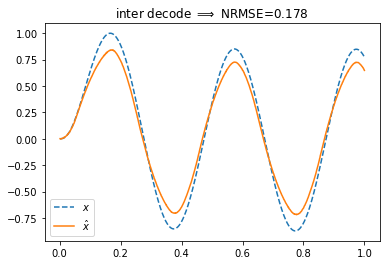

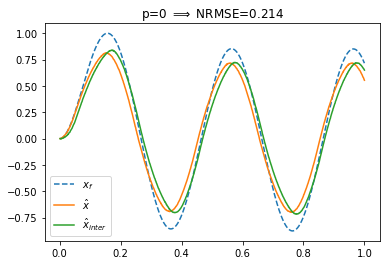

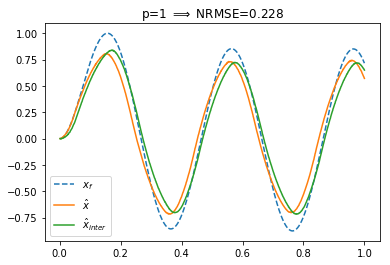

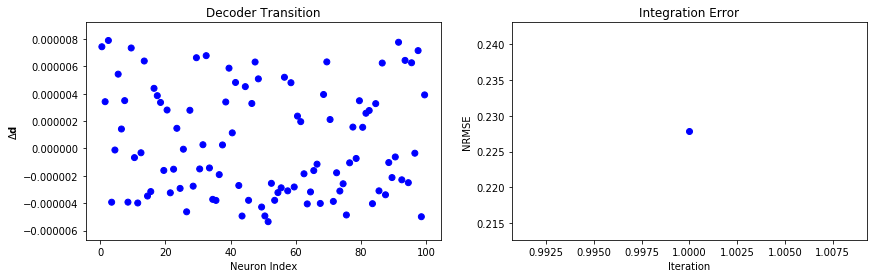

In [325]:
go4(n=100,
    freq=5*np.pi,
    verbose=True,
#     neuron_type=BahlNeuron(),
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01,
    t=1.0,
    n_syn=1)

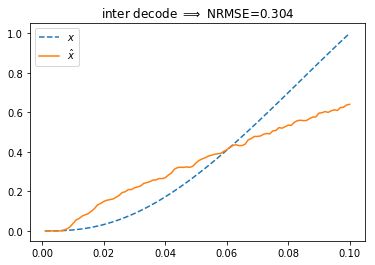

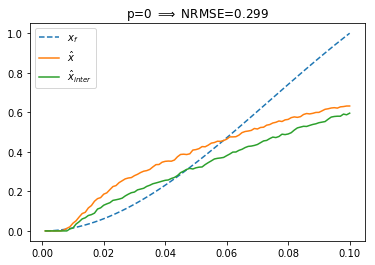

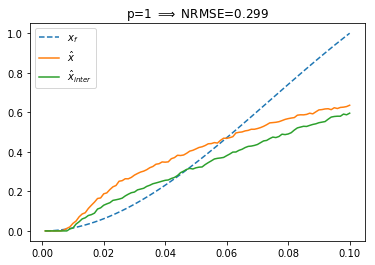

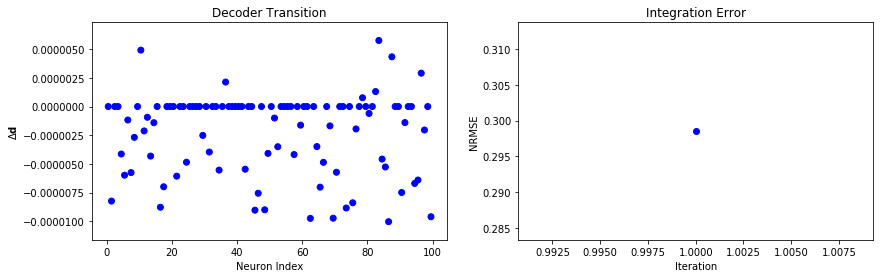

In [326]:
go4(n=100,
    freq=5*np.pi,
    verbose=True,
    neuron_type=BahlNeuron(),
#     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01,
    t=0.1,
    n_syn=1)

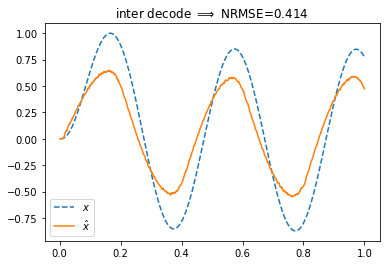

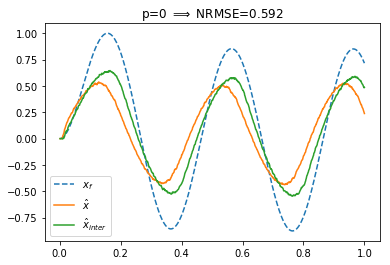

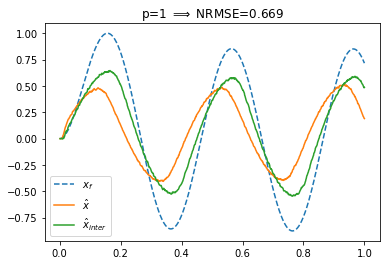

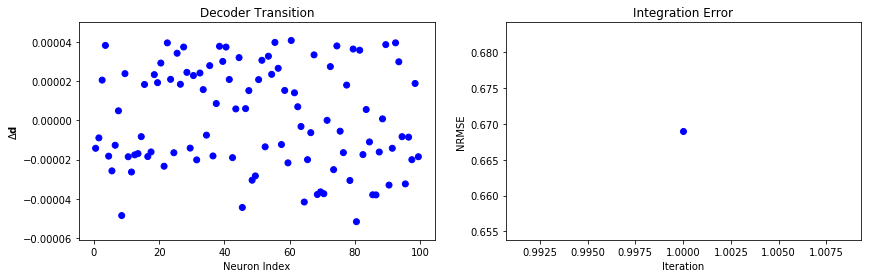

In [327]:
go4(n=100,
    freq=5*np.pi,
    verbose=True,
    neuron_type=BahlNeuron(),
#     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    n_pre2=100,
    tau_pre2=0.01,
    t=1.0,
    n_syn=1)

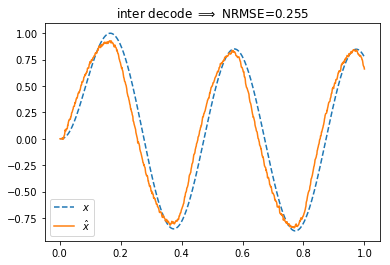

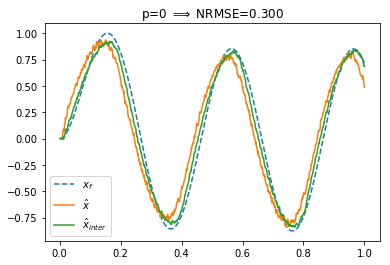

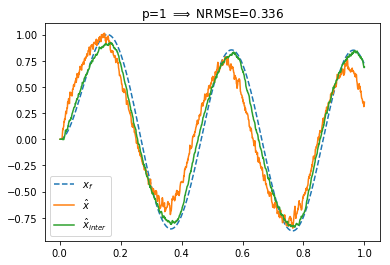

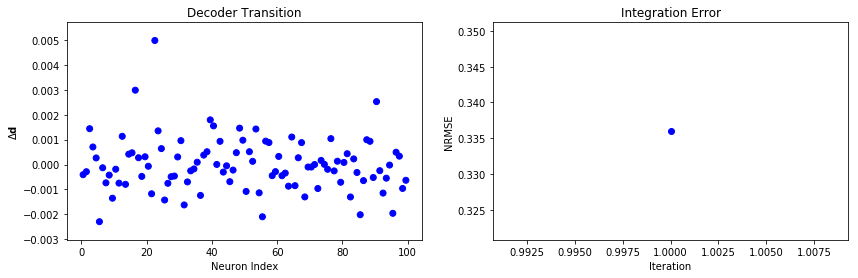

In [329]:
go4(n=100,
    freq=5*np.pi,
    verbose=True,
    neuron_type=BahlNeuron(),
    solver=nengo.solvers.LstsqL2(reg=0.1),
    n_pre2=100,
    tau_pre2=0.01,
    t=1.0,
    n_syn=1)